In [413]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import config
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### 读数据

In [414]:
train_filename = os.path.join(config.base_path, "data","train.xlsx")
test_filename = os.path.join(config.base_path, "data","测试B.xlsx")
df_train_raw = pd.read_excel(train_filename) #训练数据
df_test_raw = pd.read_excel(test_filename) #测试数据

df_train = df_train_raw.iloc[:,1:] 
df_train.index = df_train_raw.iloc[:,0].values
df_test = df_test_raw.iloc[:,1:]
df_test.index = df_test_raw.iloc[:,0].values

cols = df_train.columns
df_all = pd.concat([df_train, df_test])
df_all = df_all[cols]
print("number of train sample : %d" %df_train.shape[0])
print("number of test sample : %d" %df_test.shape[0])
print("number of features : %d" %df_test.shape[1])
print("number of all samples : %d" %df_all.shape[0])

number of train sample : 599
number of test sample : 121
number of features : 8027
number of all samples : 720


### 观察一下数据分布

0.12183846094977784


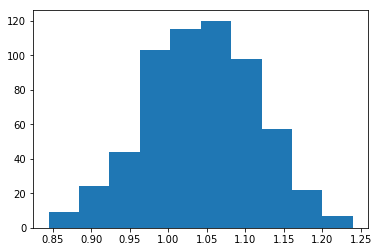

-0.0680686588206296


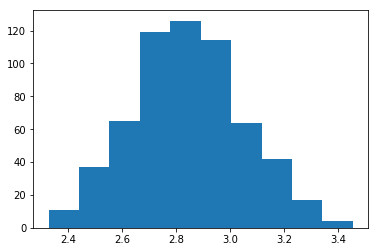

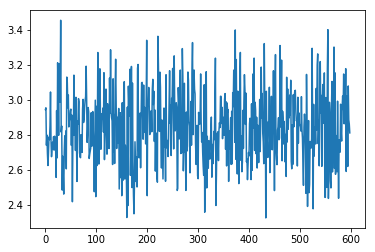

In [415]:
from scipy.stats import skew
import math
print(skew(df_train["Y"].values))
log_y = np.log(list(df_train["Y"].values))
plt.hist(log_y)
plt.show()
print(skew(log_y))
plt.hist(df_train["Y"].values)
plt.show()
plt.plot(df_train["Y"].values)
plt.show()


### 手工去除掉一些列

In [416]:
drop_list = ["312X" + str(i) for i in range(1, 51)] #这几个列和TOOL(#1)这一列冗余了
drop_list += ["340X" + str(i) for i in range(1,11)] #这几个列和tool这一列冗余了
print(drop_list)
df_all = df_all.drop(columns = drop_list)



['312X1', '312X2', '312X3', '312X4', '312X5', '312X6', '312X7', '312X8', '312X9', '312X10', '312X11', '312X12', '312X13', '312X14', '312X15', '312X16', '312X17', '312X18', '312X19', '312X20', '312X21', '312X22', '312X23', '312X24', '312X25', '312X26', '312X27', '312X28', '312X29', '312X30', '312X31', '312X32', '312X33', '312X34', '312X35', '312X36', '312X37', '312X38', '312X39', '312X40', '312X41', '312X42', '312X43', '312X44', '312X45', '312X46', '312X47', '312X48', '312X49', '312X50', '340X1', '340X2', '340X3', '340X4', '340X5', '340X6', '340X7', '340X8', '340X9', '340X10']


### 筛选出工具列和时间列

In [417]:
cols = df_all.columns
cols_time = []
for col in cols:
    if all([str(e).startswith("2017") or str(e).startswith("2016") for e in df_all[col][:20]]):
        cols_time.append(col)
    if col == "520X171":
        cols_time.append(col)
print(cols_time)

cols = df_all.columns
cols_tool = list(filter(lambda x : "tool" in x.lower(), cols))
print(cols_tool)

['210X24', '210X204', '210X205', '210X213', '210X215', '220X67', '220X71', '220X75', '220X79', '220X83', '220X87', '220X91', '220X95', '220X225', '220X226', '220X227', '220X228', '220X229', '220X230', '220X231', '220X232', '220X233', '220X234', '220X235', '220X236', '300X10', '300X20', '310X56', '310X60', '310X64', '310X68', '310X72', '310X76', '310X80', '310X84', '311X29', '311X31', '311X99', '311X100', '311X187', '311X188', '261X373', '261X374', '261X559', '261X560', '261X745', '261X746', '330X623', '330X640', '330X1165', '330X1168', '330X1169', '360X691', '360X710', '360X711', '360X1287', '360X1291', '360X1292', '360X1293', '400X7', '400X9', '400X25', '400X27', '400X60', '400X61', '400X64', '400X65', '400X83', '400X84', '400X168', '400X169', '400X219', '400X220', '420X7', '420X9', '420X25', '420X27', '420X186', '520X148', '520X152', '520X171', '520X171', '520X173', '520X248', '520X250', '520X346', '520X348', '520X354', '520X356', '750X691', '750X710', '750X711', '750X1287', '750X129

### 去掉空列和重复列，添加时间之差的特征

In [418]:
#去除掉全部为空的列
df_all.dropna(axis=1, how='all', inplace=True)
print("number of features after dropna: %d" %df_all.shape[1])

df_all = df_all.T.drop_duplicates().T
print("number of features after drop_dumplicates: %d" %df_all.shape[1])

cols = df_all.columns

cols_time = []
for col in cols:
    if all([str(e).startswith("2017") or str(e).startswith("2016") for e in df_all[col][:20]]):
        cols_time.append(col)
print(cols_time)

# #添加时间之差的列
# for i, col_a in enumerate(cols_time):

#     time_list_b = df_all[col_b].values
#     time_len = min(14, len(str(time_list_a[0])), len(str(time_list_b[0])))
#     print(col_a, col_b)
#     if time_len < 14:
#         continue
#     else:
#         time_format = "%Y%m%d%H%M%S"
#     time_delta = [abs((datetime.strptime(str(time_list_a[i])[:time_len], time_format) - datetime.strptime(str(time_list_b[i])[:time_len], time_format)).total_seconds()) for i in range(df_all.shape[0])]
#     df_all[col_a + '-' + col_b] = time_delta
        
        
        

cols_time.append("520X171")

number of features after dropna: 7906
number of features after drop_dumplicates: 3438
['210X24', '210X204', '210X205', '210X213', '210X215', '220X67', '220X71', '220X75', '220X79', '220X83', '220X87', '220X91', '220X95', '220X225', '220X227', '220X228', '220X229', '220X230', '220X231', '220X233', '220X235', '300X10', '300X20', '310X56', '310X60', '310X64', '310X68', '310X72', '310X76', '310X80', '310X84', '311X29', '311X31', '311X99', '311X100', '311X187', '311X188', '261X373', '261X374', '261X559', '261X560', '261X745', '261X746', '330X623', '360X691', '400X7', '400X9', '400X25', '400X27', '400X60', '400X61', '400X64', '400X84', '400X169', '420X7', '420X9', '420X25', '420X27', '420X186', '520X148', '520X152', '520X171', '520X173', '520X250', '520X346', '520X348', '750X691']


### 去除时间列

In [419]:
# 去掉完全重复的列和时间列
dropped_col = []
for i in set(cols)-set(cols_tool):
    if len(set(df_all[i])) <= 1:
        dropped_col.append(i)
df_all.loc[:,dropped_col+cols_time].to_csv(os.path.join(config.base_path, "data", "重复的列和时间.csv"))
df_all = df_all.drop(labels=dropped_col, axis=1)
df_all = df_all.drop(labels=cols_time, axis=1)
print("number of features : %d" %(df_all.shape[1]-1))
print('TOOL_ID (#3)' in list(df_all.columns))

number of features : 3299
True


### Label Encoder

In [420]:
le = LabelEncoder()
for col in cols_tool:
    tools = df_all[col].values
    df_all[col] = le.fit_transform(tools)
# print(df_all[cols_tool[0]])
        

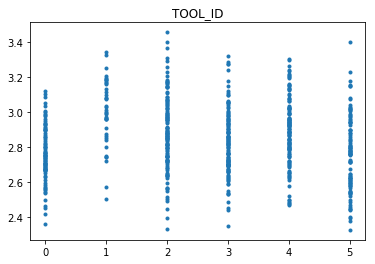

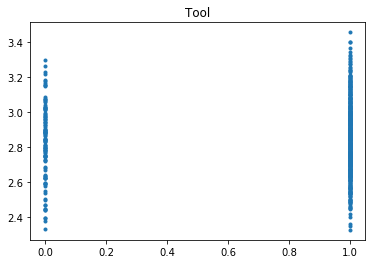

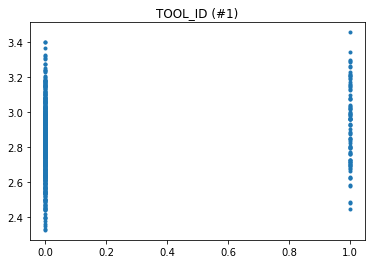

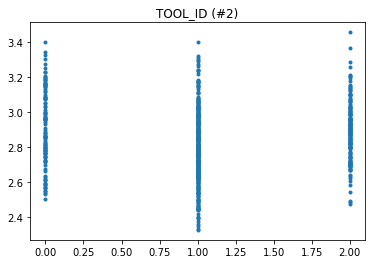

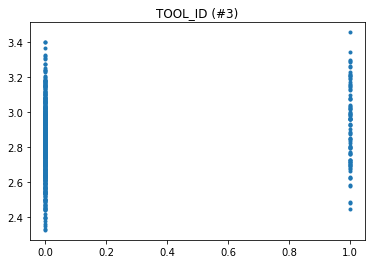

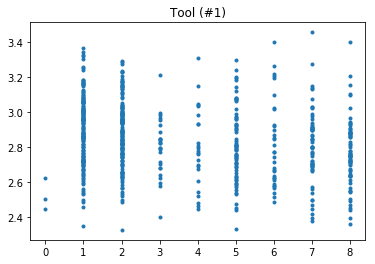

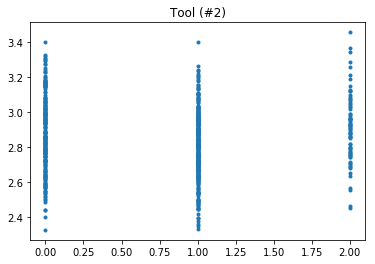

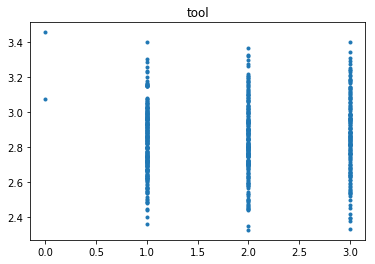

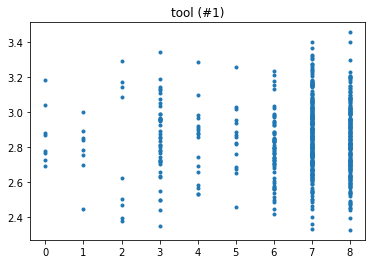

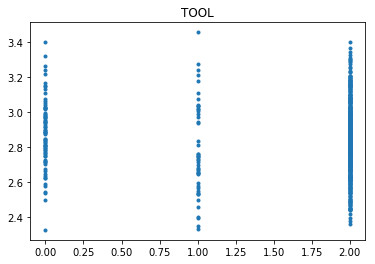

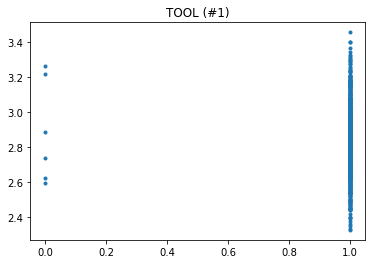

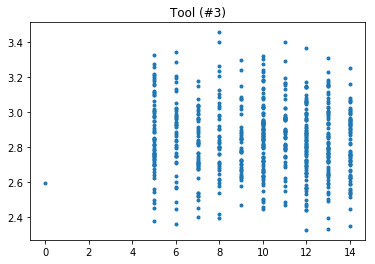

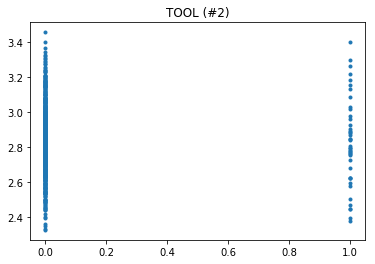

In [421]:
for col in cols_tool:
    plt.plot(df_all[col], df_all["Y"], '.')
    plt.gca().set_title(col)
    plt.show()

### 按不同工序的不同工具缺失值填充和数据标准化

In [422]:
# 按照不同的TOOL类别填充均值
cols = df_all.columns
# cols_tool = list(filter(lambda x : "tool" in x.lower(), cols))
# print(cols_tool)

scaler = StandardScaler()
for i in range(len(cols_tool) - 1):
    df_tmp = df_all.loc[:,cols_tool[i]:cols_tool[i+1]].iloc[:,:-1]
    tools = df_tmp[cols_tool[i]]
    tool_set = list(set(tools))
    for k, tool in enumerate(tool_set):
        df_tool = df_tmp.loc[df_tmp[cols_tool[i]]==tool]
        mean_tool = df_tool.mean().fillna(0)
        df_tool = df_tool.fillna(mean_tool)
        
#         df_tool = pd.DataFrame(scaler.fit_transform(df_tool.values), index = df_tool.index, columns = df_tool.columns)

        print("--%s: %s done--" %(cols_tool[i], tool))
        if k == 0:
            tmp = df_tool
        else:
            tmp = pd.concat([tmp, df_tool])
    if i == 0:
        tool_frame = tmp
    else:
        tool_frame = pd.concat([tool_frame, tmp], axis = 1)
    
        
df_tmp = df_all.loc[:,cols_tool[-1]:].iloc[:,:-1]
tools = df_tmp[cols_tool[-1]]
tool_set = list(set(tools))
for k, tool in enumerate(tool_set):
    df_tool = df_tmp.loc[df_tmp[cols_tool[-1]]==tool]
    mean_tool = df_tool.mean().fillna(0)
    df_tool = df_tool.fillna(mean_tool)
#     df_tool = pd.DataFrame(scaler.fit_transform(df_tool.values), index = df_tool.index, columns = df_tool.columns)
    print("--%s: %s done--" %(cols_tool[-1], tool))
    if k == 0:
        tmp = df_tool
    else:
        tmp = pd.concat([tmp, df_tool])
tool_frame = pd.concat([tool_frame, tmp, df_all["Y"]], axis = 1)

        
df_all = tool_frame[cols]
print('TOOL_ID (#3)' in list(df_all.columns))

--TOOL_ID: 0 done--
--TOOL_ID: 1 done--
--TOOL_ID: 2 done--
--TOOL_ID: 3 done--
--TOOL_ID: 4 done--
--TOOL_ID: 5 done--
--Tool: 0 done--
--Tool: 1 done--
--TOOL_ID (#1): 0 done--
--TOOL_ID (#1): 1 done--
--TOOL_ID (#2): 0 done--
--TOOL_ID (#2): 1 done--
--TOOL_ID (#2): 2 done--
--TOOL_ID (#3): 0 done--
--TOOL_ID (#3): 1 done--
--Tool (#1): 0 done--
--Tool (#1): 1 done--
--Tool (#1): 2 done--
--Tool (#1): 3 done--
--Tool (#1): 4 done--
--Tool (#1): 5 done--
--Tool (#1): 6 done--
--Tool (#1): 7 done--
--Tool (#1): 8 done--
--Tool (#2): 0 done--
--Tool (#2): 1 done--
--Tool (#2): 2 done--
--tool: 0 done--
--tool: 1 done--
--tool: 2 done--
--tool: 3 done--
--tool (#1): 0 done--
--tool (#1): 1 done--
--tool (#1): 2 done--
--tool (#1): 3 done--
--tool (#1): 4 done--
--tool (#1): 5 done--
--tool (#1): 6 done--
--tool (#1): 7 done--
--tool (#1): 8 done--
--TOOL: 0 done--
--TOOL: 1 done--
--TOOL: 2 done--
--TOOL (#1): 0 done--
--TOOL (#1): 1 done--
--Tool (#3): 0 done--
--Tool (#3): 1 done--
--

### 填充之后再去一遍重

In [423]:
df_all = df_all.T.drop_duplicates().T
print("number of features after drop_dumplicates: %d" %df_all.shape[1])

cols = df_all.columns

# 去掉完全重复的列
dropped_col = []
for i in set(cols)-set(cols_tool):
    if len(set(df_all[i])) <= 1:
        dropped_col.append(i)
df_all.loc[:,dropped_col].to_csv(os.path.join(config.base_path, "data", "重复的列.csv"))
df_all = df_all.drop(labels=dropped_col, axis=1)
print(dropped_col)
print("number of features : %d" %(df_all.shape[1]-1))
print('TOOL_ID (#3)' in cols)

number of features after drop_dumplicates: 3276
['400X17', '400X107', '520X292', '750X717', '220X396', '520X54', '300X15', '400X24', '220X35', '520X185', '420X143', '220X237', '750X692', '220X25', '311X24', '520X298', '520X2', '750X5', '520X175', '400X39', '220X242', '220X532', '400X226', '520X4', '400X29', '420X39', '300X17', '520X429', '400X40']
number of features : 3246
False


### OneHotEncoder

In [424]:
cols = df_all.columns
# cols_tool = list(filter(lambda x : "tool" in x.lower(), cols))
# print(cols_tool)
# df_all = pd.get_dummies(df_all, prefix = cols_tool, columns = cols_tool)

### 还原train和test数据

In [425]:
#print(df_all_fillna.loc["ID563","312X211"])

df_train = df_all.loc[df_train.index,:]
df_test = df_all.loc[df_test.index,:].drop("Y", axis = 1)
print(df_train.columns)
# print(df_test.index)
print("number of train sample : %d" %df_train.shape[0])
print("number of test sample : %d" %df_test.shape[0])
print("number of features : %d" %df_test.shape[1])

Index(['TOOL_ID', '210X1', '210X2', '210X3', '210X4', '210X5', '210X6',
       '210X7', '210X8', '210X9',
       ...
       '750X1288', '750X1296', '750X1298', '750X1306', '750X1312', '750X1314',
       '750X1330', '750X1357', '750X1384', 'Y'],
      dtype='object', length=3247)
number of train sample : 599
number of test sample : 121
number of features : 3246


### 按照相关系数筛选

In [426]:
corr_values = []
k = 200
for col in df_test.columns[:-1]:
    corr_values.append(abs(pearsonr(df_train[col].values,df_train['Y'])[0]))
corr_df = pd.DataFrame({'col':df_test.columns[:-1], 'corr_value':corr_values})
corr_df = corr_df.sort_values(by='corr_value',ascending=False)
selected = corr_df['col'].values[:k]

df_train_corr = df_train.loc[:, list(selected) + ['Y']]
df_test_corr = df_test.loc[:, list(selected)]

D:\Anaconda\Anaconda\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
D:\Anaconda\Anaconda\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


### 按树模型筛选

In [427]:
k = 100
X_train = df_train.values[:, 0:-1]
Y_train = df_train.values[:,-1]
X_test = df_test.values[:,:]
# x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, random_state = 1024, test_size=0.1)

# reg = GradientBoostingRegressor(random_state = 0,
#                                 learning_rate = 0.1,
#                                 n_estimators= 29,
#                                 min_samples_split=2,
#                                 min_samples_leaf=5,
#                                 max_features=0.81,
#                                 subsample= 0.8,
#                                 max_depth= 6,
# )
reg = XGBRegressor(random_state = 0,
                    learning_rate = 0.1,
                    n_estimators= 49,
                    subsample= 0.78,
                    colsample_bytree= 0.62,
                    max_depth= 3,
)
reg.fit(X_train, Y_train)
sorted_imp = sorted(reg.feature_importances_, reverse=True)
k = sorted_imp.index(0) - 1
print("---Xgboost feature importance: %dth---" %k)
print(sorted_imp[k])
importance_df = pd.DataFrame({'col':df_test.columns, 'importance':reg.feature_importances_})
importance_df = importance_df.sort_values(by="importance", ascending=False)
selected = importance_df['col'].values[:k + 1]
df_train_tree = df_train.loc[:, list(selected) + ['Y']]
df_test_tree = df_test.loc[:, list(selected)]

---Xgboost feature importance: 237th---
0.00358423


### 写入文件

In [428]:
after_file = os.path.join(config.base_path, "data", "feature_selected_AB_all_category.xlsx")
with pd.ExcelWriter(after_file) as writer:
    df_train.to_excel(writer,sheet_name = "train_data")
    df_test.to_excel(writer, sheet_name = "test_data")

after_file = os.path.join(config.base_path, "data", "feature_selected_AB_200_category.xlsx")
with pd.ExcelWriter(after_file) as writer:
    df_train_corr.to_excel(writer,sheet_name = "train_data")
    df_test_corr.to_excel(writer, sheet_name = "test_data")

after_file = os.path.join(config.base_path, "data", "xgbtree_feature_selected_AB_category.xlsx")
with pd.ExcelWriter(after_file) as writer:
    df_train_tree.to_excel(writer,sheet_name = "train_data")
    df_test_tree.to_excel(writer, sheet_name = "test_data")